In [21]:
import numpy as np
import pandas as pd
import configparser
import os  # Import os library for path operations

# Read configuration from config.ini
config = configparser.ConfigParser()
config.read('config.ini')

import scipy.stats as stats


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)


In [24]:

def read_csv_and_preprocess(file_path):
    """
    Read CSV file and perform necessary preprocessing.

    Parameters:
    - file_path (str): Path to the CSV file.

    Returns:
    - pd.DataFrame: Processed DataFrame.
    """

    # Ensure the file path exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")



    # Define data types and index column
    data_types = {
        'ds': 'str',
        'unique_id': 'category',
        'y': np.int64
    }
    index_col = 'ds'

    # Read CSV with specified data types and index
    df = pd.read_csv(file_path, dtype=data_types, parse_dates=[index_col])

    # Check if 'ds' is present in the columns
    if 'ds' not in df.columns:
        raise KeyError("The 'ds' column is not present in the DataFrame.")

    # Convert 'ds' column to datetime after reading
    df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m')  # Adjust the format based on your actual data
    
    df = df[['unique_id', 'ds', 'y']]
    
    return df

In [ ]:
# Example usage:
df_path = config['Paths']['dataset_data']
df = read_csv_and_preprocess(df_path)


In [33]:
df.head(), df.shape

(   unique_id         ds   y
 0        101 2018-01-01   0
 1        101 2018-02-01  20
 2        101 2018-03-01   1
 3        101 2018-04-01  40
 4        101 2018-05-01   6,
 (2829, 3))

## Forecasting with AutoARIMA and AutoETS

### Start the models

In [37]:
from statsforecast.models import (
    AutoARIMA,
    AutoETS
)
from statsforecast import StatsForecast

In [28]:
models= [
    AutoARIMA(season_length=12),
    AutoETS(season_length=12)
]

In [38]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=df, 
    models=models,
    freq='MS', 
    n_jobs=-1
)

### Split data into training and testing

In [34]:
train = df[df.ds<='2023-01-01'] 
test = df[df.ds>'2023-01-01']

In [35]:
train.shape, test.shape

((2501, 3), (328, 3))

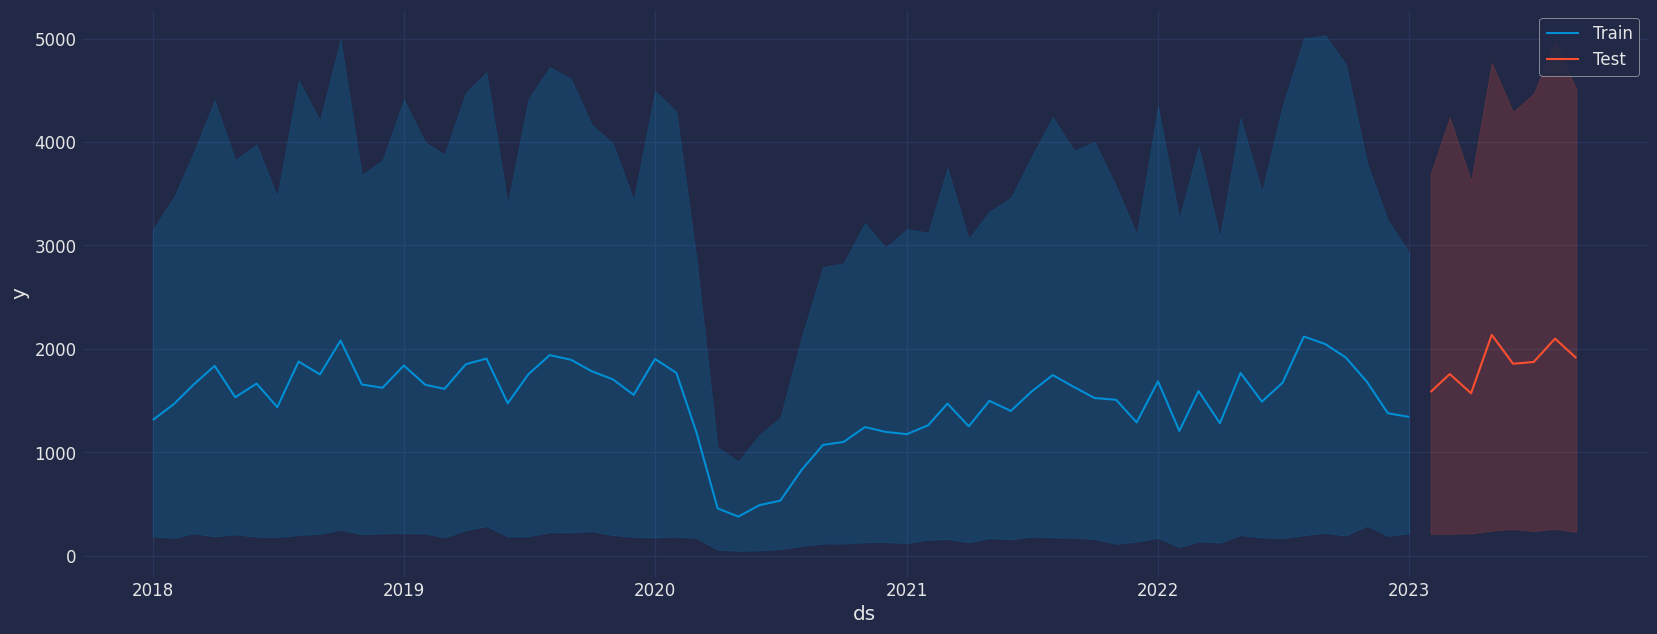

In [36]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.show()


In [39]:
forecast_df = sf.forecast(h=12, level=[90])
forecast_df.head()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90
unique_id,,,,,,,
101,2023-10-01,281.481812,206.822495,356.141144,407.739807,336.590576,478.889038
101,2023-11-01,281.481812,196.323959,366.639679,426.429779,354.494141,498.365417
101,2023-12-01,281.481812,186.984695,375.978943,445.119781,370.123749,520.115784
101,2024-01-01,281.481812,178.488846,384.474792,463.809753,382.349060,545.270447
101,2024-02-01,281.481812,170.642303,392.321350,482.499725,390.664673,574.334778


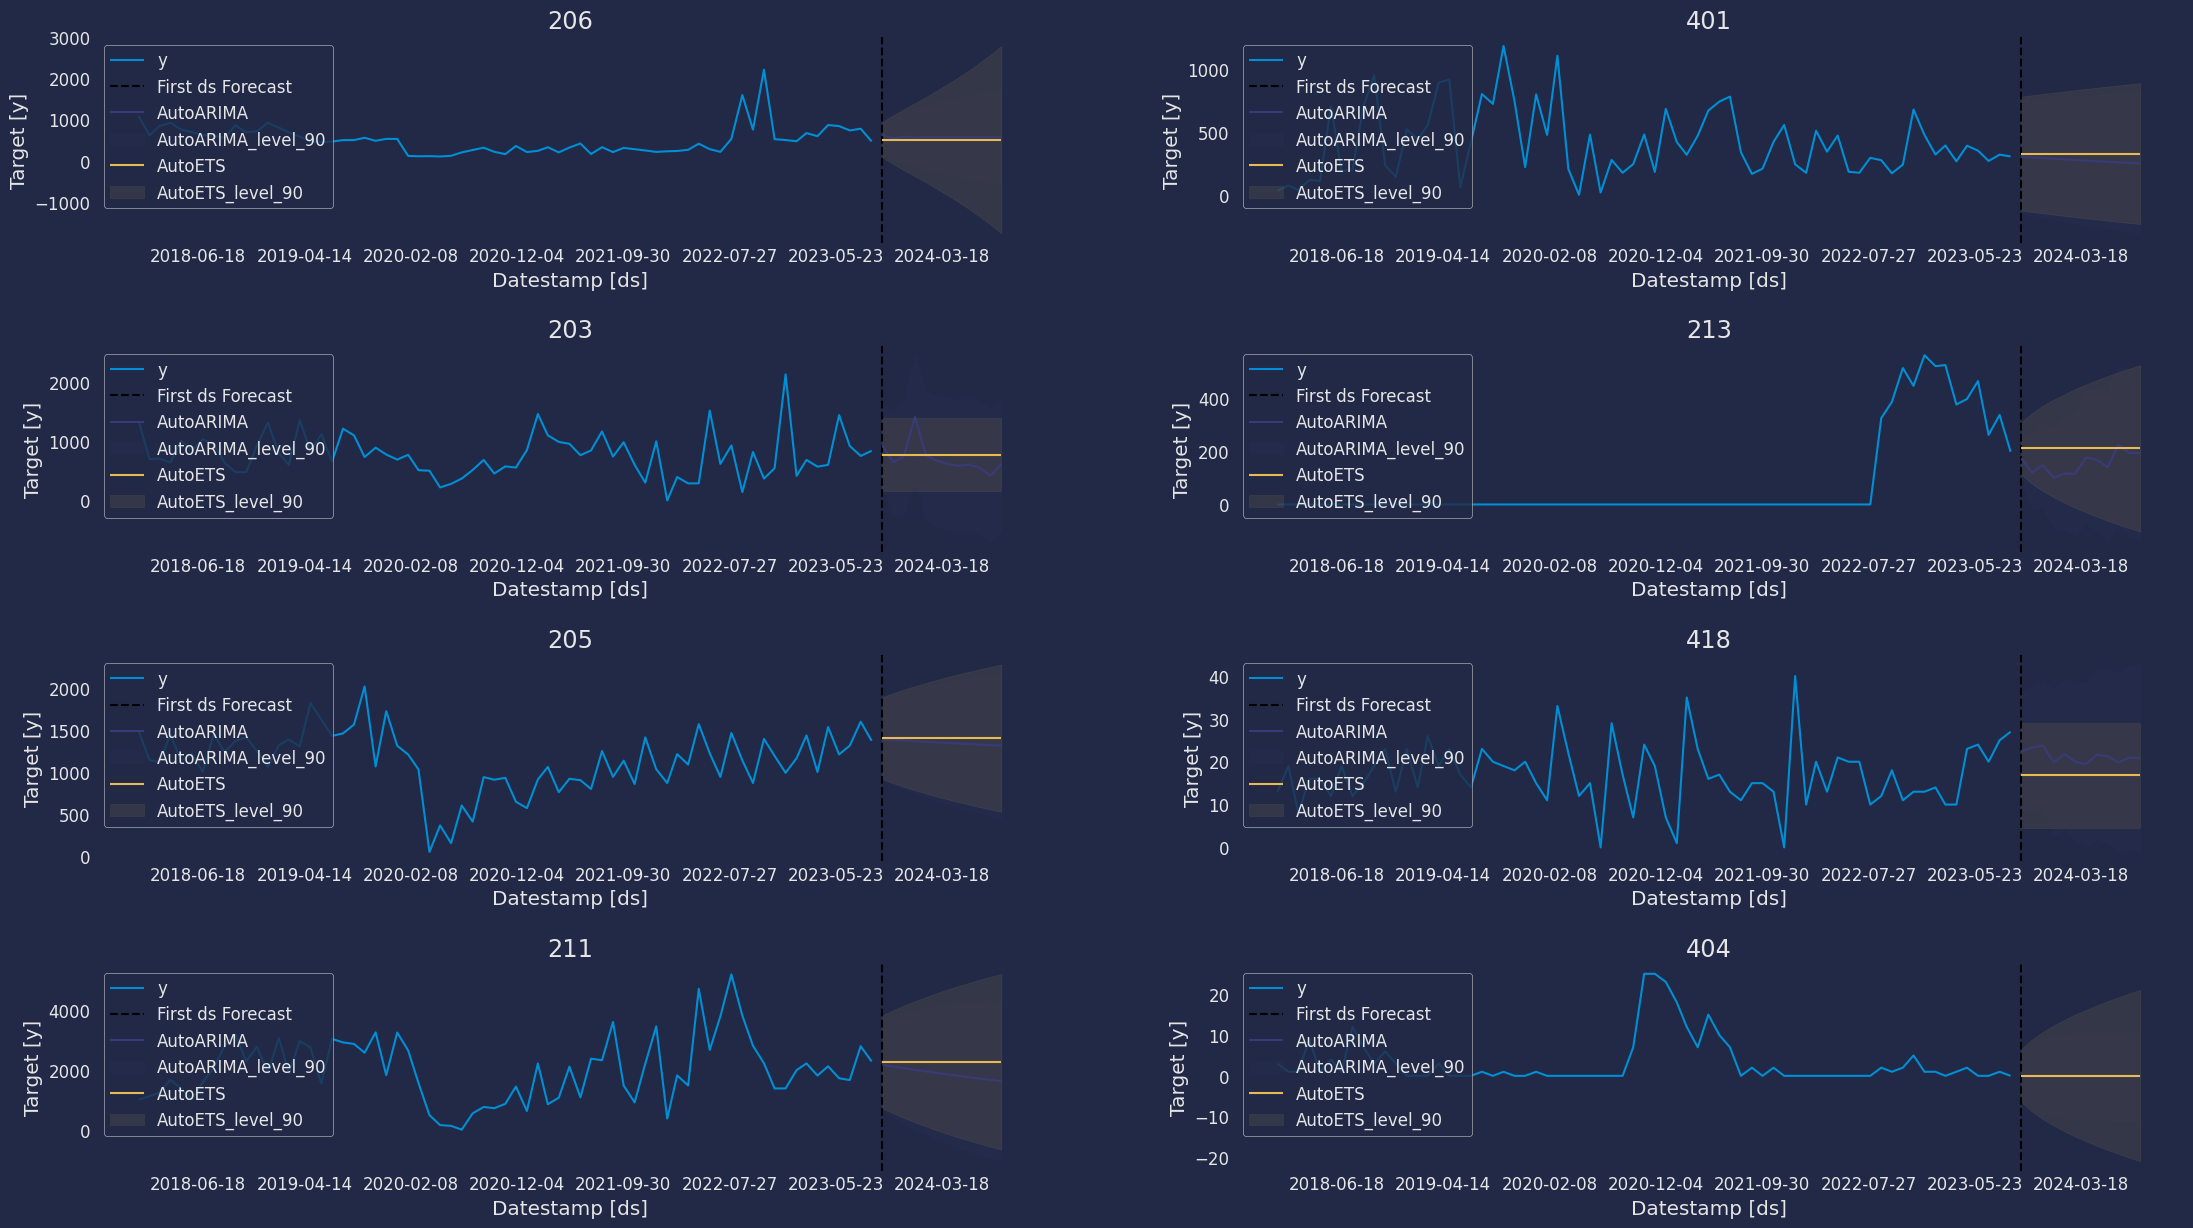

In [41]:
sf.plot(df, forecast_df, engine='matplotlib')

In [42]:
crossvaldation_df = sf.cross_validation(
    df=df,
    h=12,
    step_size=24,
    n_windows=2
  )

In [43]:
crossvaldation_df.head()


,ds,cutoff,y,AutoARIMA,AutoETS
unique_id,,,,,
101,2020-10-01,2020-09-01,0.0,2.150877,2.096327
101,2020-11-01,2020-09-01,0.0,-0.247019,2.096327
101,2020-12-01,2020-09-01,4.0,3.112188,2.096327
101,2021-01-01,2020-09-01,4.0,3.767208,2.096327
101,2021-02-01,2020-09-01,4.0,3.558483,2.096327


In [45]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate


In [46]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [47]:
evaluation_df = evaluate_cross_validation(crossvaldation_df.reset_index(), mse)

evaluation_df.head()


,AutoARIMA,AutoETS,best_model
unique_id,,,
101,2.249714e+04,2.339212e+04,AutoARIMA
102,4.166667e-02,1.555650e-04,AutoETS
201,7.253578e+03,2.534817e+03,AutoETS
202,3.595685e+08,1.039829e+08,AutoETS
203,5.476392e+05,2.415817e+05,AutoETS


In [48]:
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()

summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]


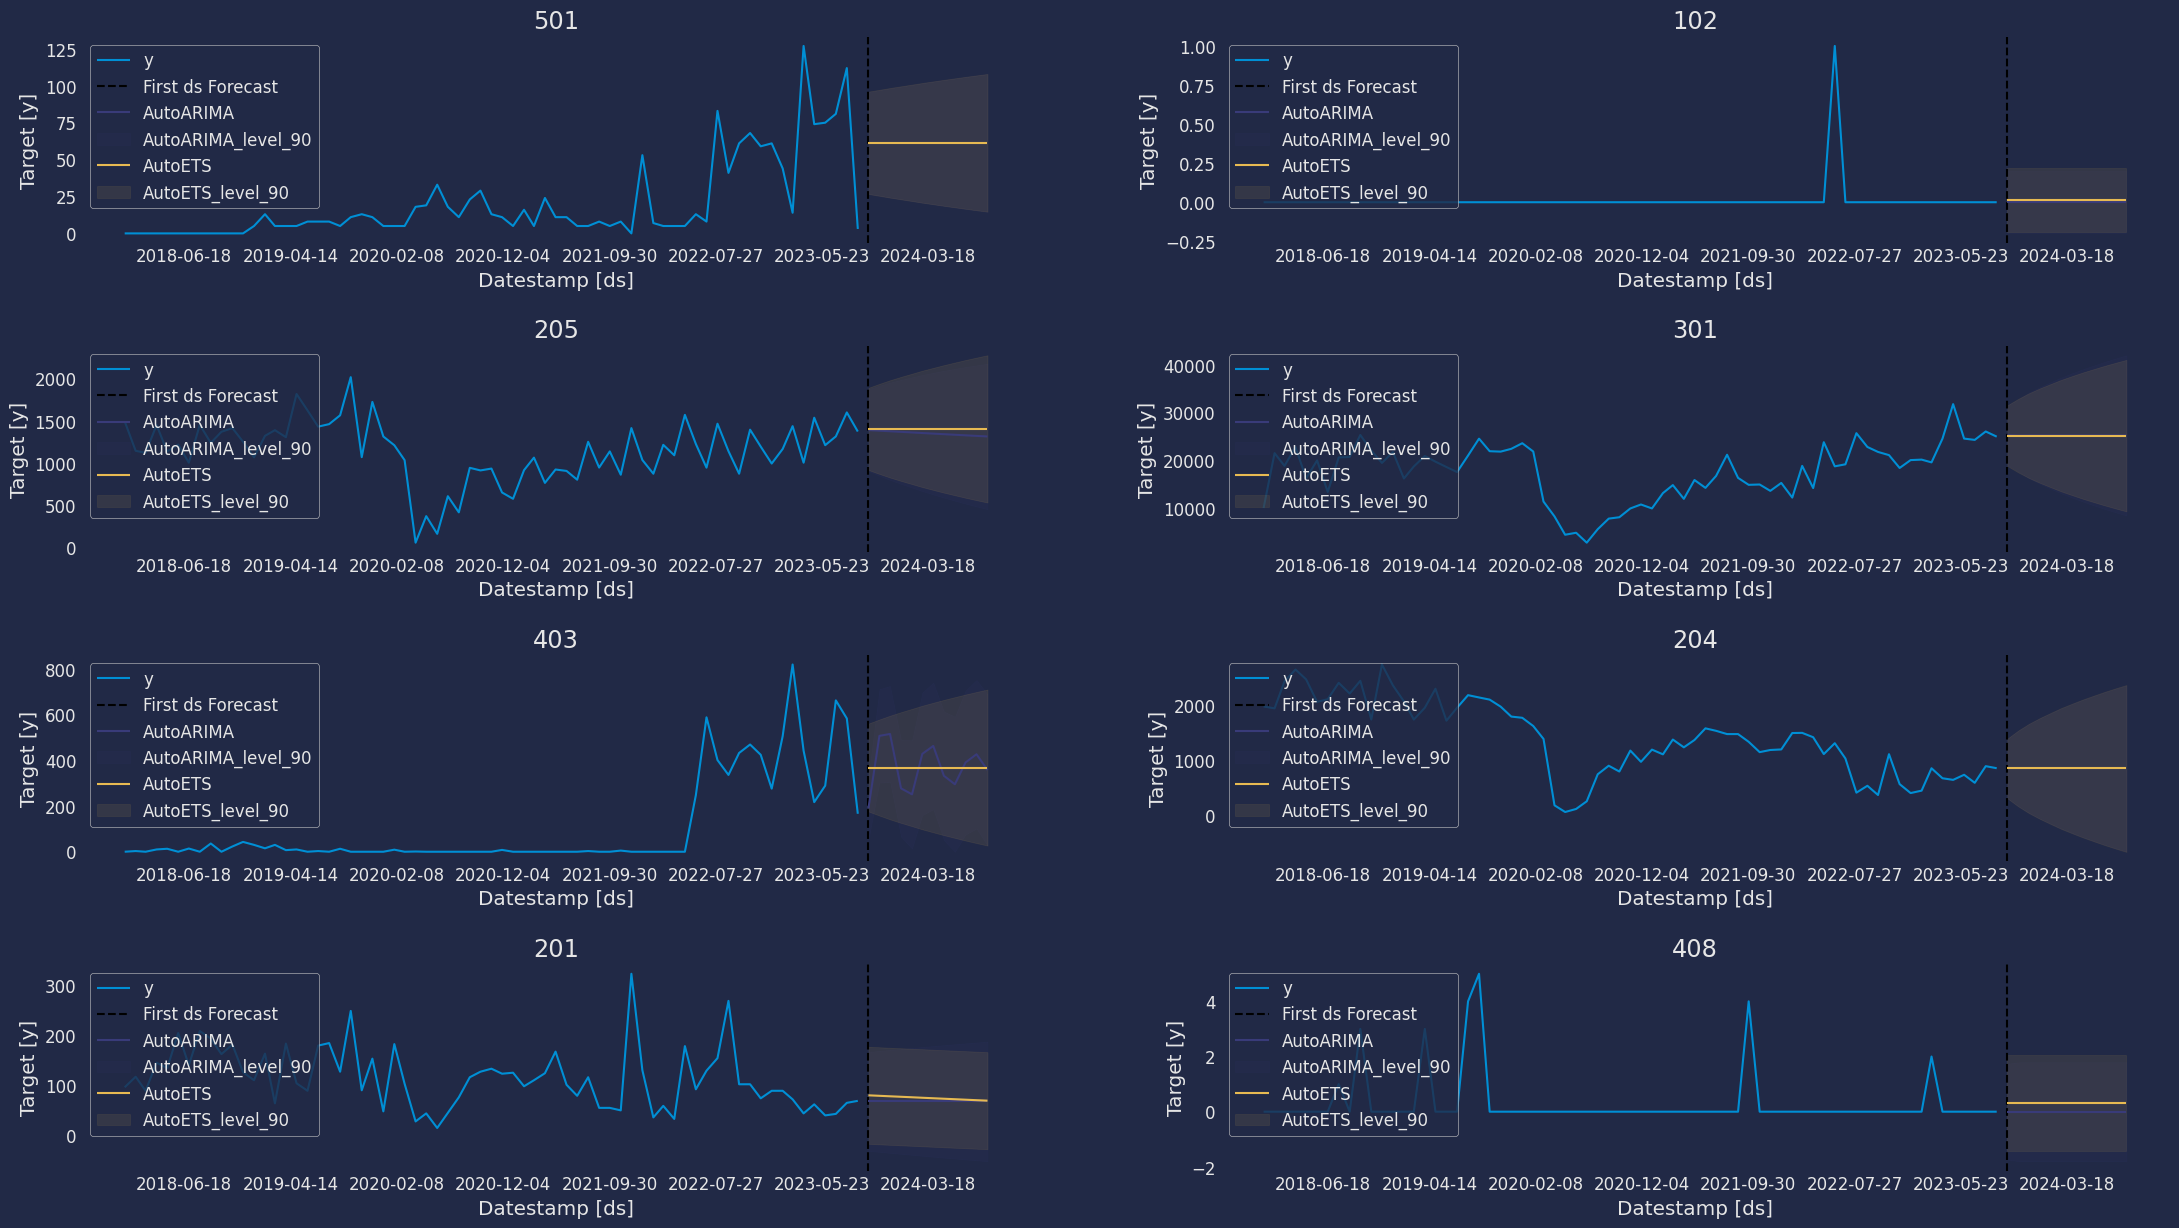

In [50]:
seasonal_ids = evaluation_df.query('best_model == "AutoETS"').index

sf.plot(df=df,forecasts_df=forecast_df, unique_ids=seasonal_ids, engine='matplotlib')


In [51]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index('ds', append=True).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df = df.reset_index(level=1)
    return df


In [52]:
prod_forecasts_df = get_best_model_forecast(forecast_df, evaluation_df)

prod_forecasts_df


model,ds,best_model,best_model-hi-90,best_model-lo-90
unique_id,,,,
101,2023-10-01,281.481812,356.141144,206.822495
101,2023-11-01,281.481812,366.639679,196.323959
101,2023-12-01,281.481812,375.978943,186.984695
101,2024-01-01,281.481812,384.474792,178.488846
101,2024-02-01,281.481812,392.321350,170.642303
...,...,...,...,...
702,2024-05-01,23.489714,52.112526,-5.133099
702,2024-06-01,23.155556,52.399628,-6.088517
702,2024-07-01,22.826075,52.661308,-7.009159


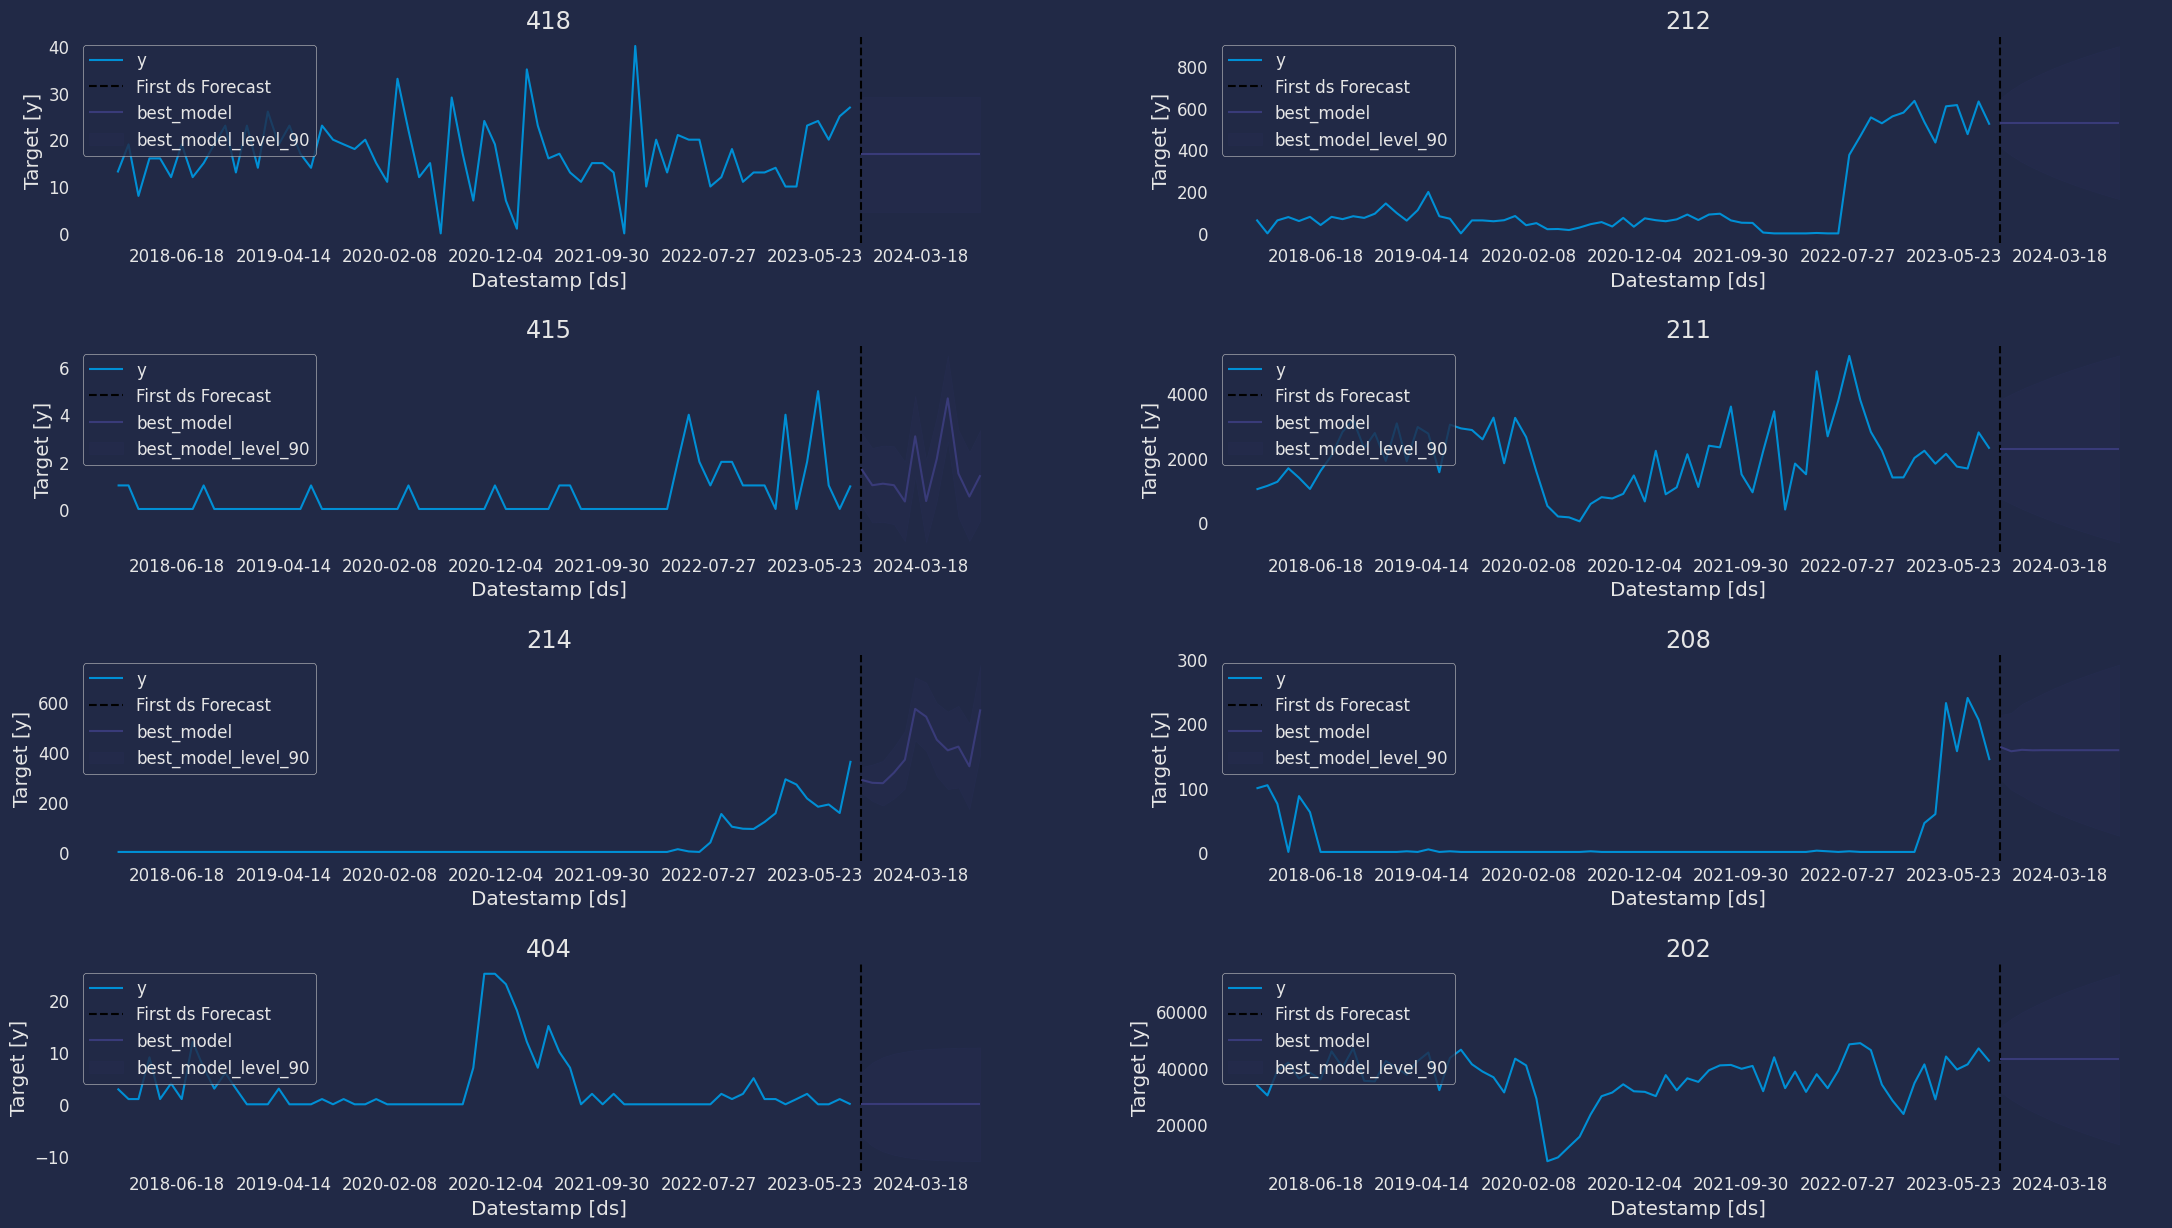

In [53]:
sf.plot(df, prod_forecasts_df, level=[90], engine='matplotlib')
